In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.utils.data as data
import torch.nn.functional as F
import os, glob
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from packages.visual_utils import *
from packages.data_utils import *
from packages.training import Pangolin, PangolinEXP

L = 32
# convolution window size in residual units
W = np.asarray([11, 11, 11, 11, 11, 11, 11, 11,
                21, 21, 21, 21, 41, 41, 41, 41])
# atrous rate in residual units
AR = np.asarray([1, 1, 1, 1, 4, 4, 4, 4,
                 10, 10, 10, 10, 25, 25, 25, 25])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [19]:
!aws s3 cp s3://research.luffingfuturellc/Pangolin ./Model/

download: s3://research.luffingfuturellc/Pangolin to Model/Pangolin


In [2]:
list_model = glob.glob("Model/*.pt")
print (list_model)

['Model/final.5.7.3.pt']


In [32]:
#Load the Pretrained Model
#seq_model = PangolinEXP(L=L, W=W, AR=AR)
seq_model = Pangolin(L=L, W=W, AR=AR)
model_path = 'gene_merged_training_data_model.pt'#'Model/demo_pangolin_same_model.pt'
#'Model/final.5.7.3.pt'#'Model/2027sTS_training_data_sequece_exp_model.pt'
#''Model/500_102S_model_exp.pt' ##'Model/final.5.7.3.pt'
state_dict = torch.load(model_path, map_location=device, weights_only=True)
seq_model.load_state_dict(state_dict)

# Move model to GPU################
seq_model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(seq_model.parameters()).device)

# Load preprocessed training data
#data = torch.load("500_102S_training_data_sequece_exp.pt", weights_only=True)
data = torch.load("gene_merged_training_data.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:
print("Loading Data: ", len(training_input))
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

test_output = seq_model(training_input[:, :4, :].to(device)).detach().cpu()[:, 0:3, :]

Model device: cuda:0
Loading Data:  1


In [ ]:
## merge gene
# --- Constants ---
DB_PATH = "/home/xli_p14/github/DL_RNA_Splicing/raw_data/annotation/gencode.v48.annotation.db"
MAJIQ_TSV = "./raw_data/PSI/2027sTS.psi.tsv"
PADDING = 5000
BLOCK_SIZE = 15000

# Load MAJIQ quantification file
majiq_df = pd.read_csv(MAJIQ_TSV, sep="\s+")[0:1]

# Group rows by gene_id
gene_groups = defaultdict(list)
for _, row in majiq_df.iterrows():
    gene_groups[row['gene_id']].append(row)

# Prepare training data
training_input = []
training_label = []

for gene, rows in gene_groups.items():
    psi_map = {}
    # Merge PSI values from all LSVs of the same gene
    for row in rows:
        psi_values = list(map(float, row['mean_psi_per_lsv_junction'].split(';')))
        junction_coords = row['junctions_coords'].split(';')
        for junc, psi in zip(junction_coords, psi_values):
            try:
                start, end = parse_coords(junc)
                psi_map[start] = psi
                psi_map[end] = psi
            except Exception as e:
                print(f"Failed to parse junction '{junc}': {e}")
                continue

    # Get gene region
    result = get_gene_bounds(gene, DB_PATH)
    if result is None:
        print(f"Skipping {gene} – gene bounds not found.")
        continue
    chrom, strand, tss, tes = result
    print(f"Gene: {gene} – Coordinates: {chrom} {strand} {tss} {tes}")
    
    # Create sequence blocks
    start = min(tss, tes)
    end = max(tss, tes)
    blocks = make_blocks(start, end, chrom, genome, PADDING, BLOCK_SIZE)
    for block_start, block_end, seq in blocks:
        if seq.count('N')>= PADDING:
            print (seq.count('N'), "out of ", BLOCK_SIZE, "Skip")
            continue
        X = one_hot_encode(seq)  # Shape: [4, BLOCK_SIZE]
        y = assign_labels(block_start, block_end, psi_map, PADDING, BLOCK_SIZE)  # Shape: [12, label_len]
        training_input.append(torch.tensor(X, dtype=torch.float32))
        training_label.append(torch.tensor(y, dtype=torch.float32))

print(f"✅ Prepared {len(training_input)} training blocks from gene-merged junctions.")
torch.save({'X': training_input, 'y': training_label}, "gene_merged_training_data.pt")

In [20]:
#plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")

0


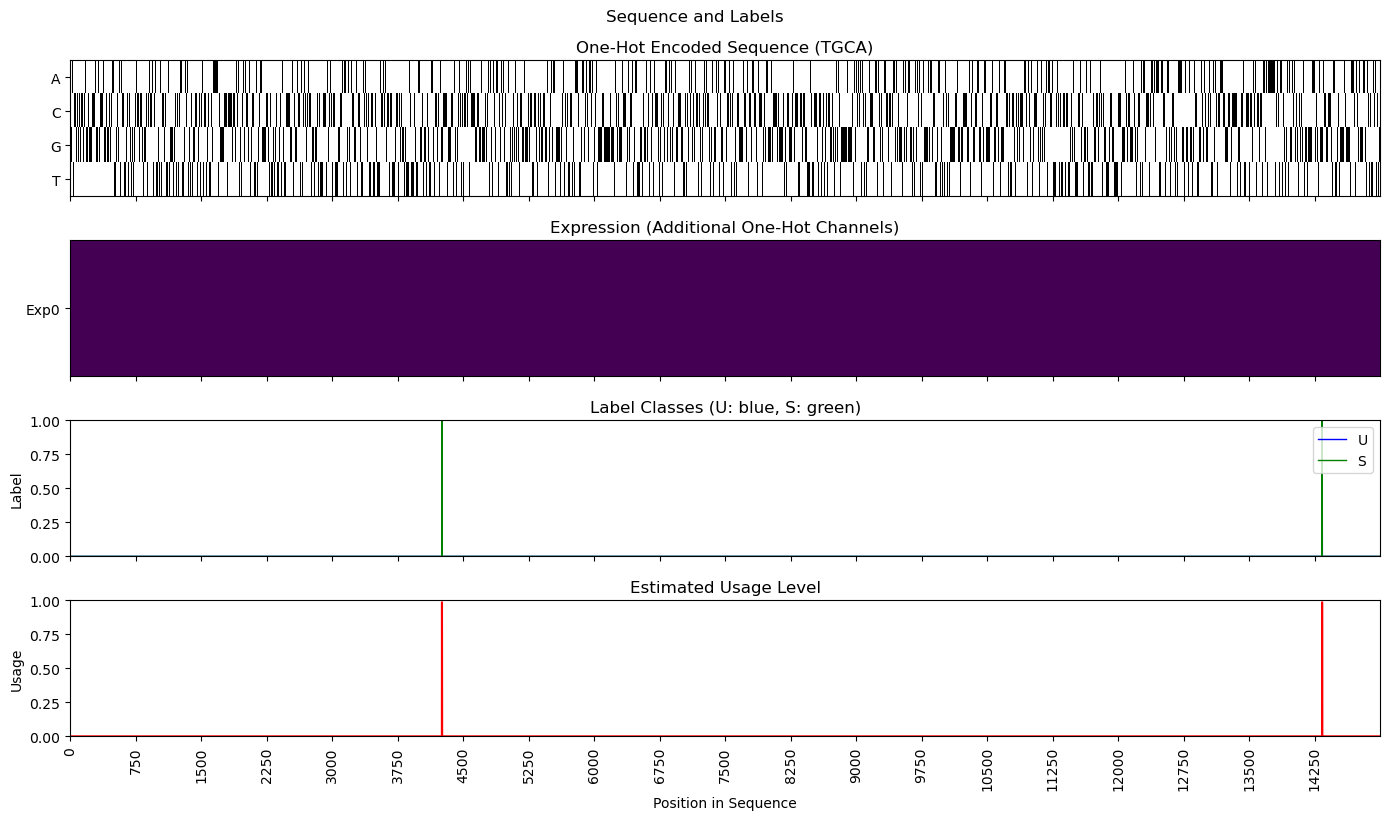

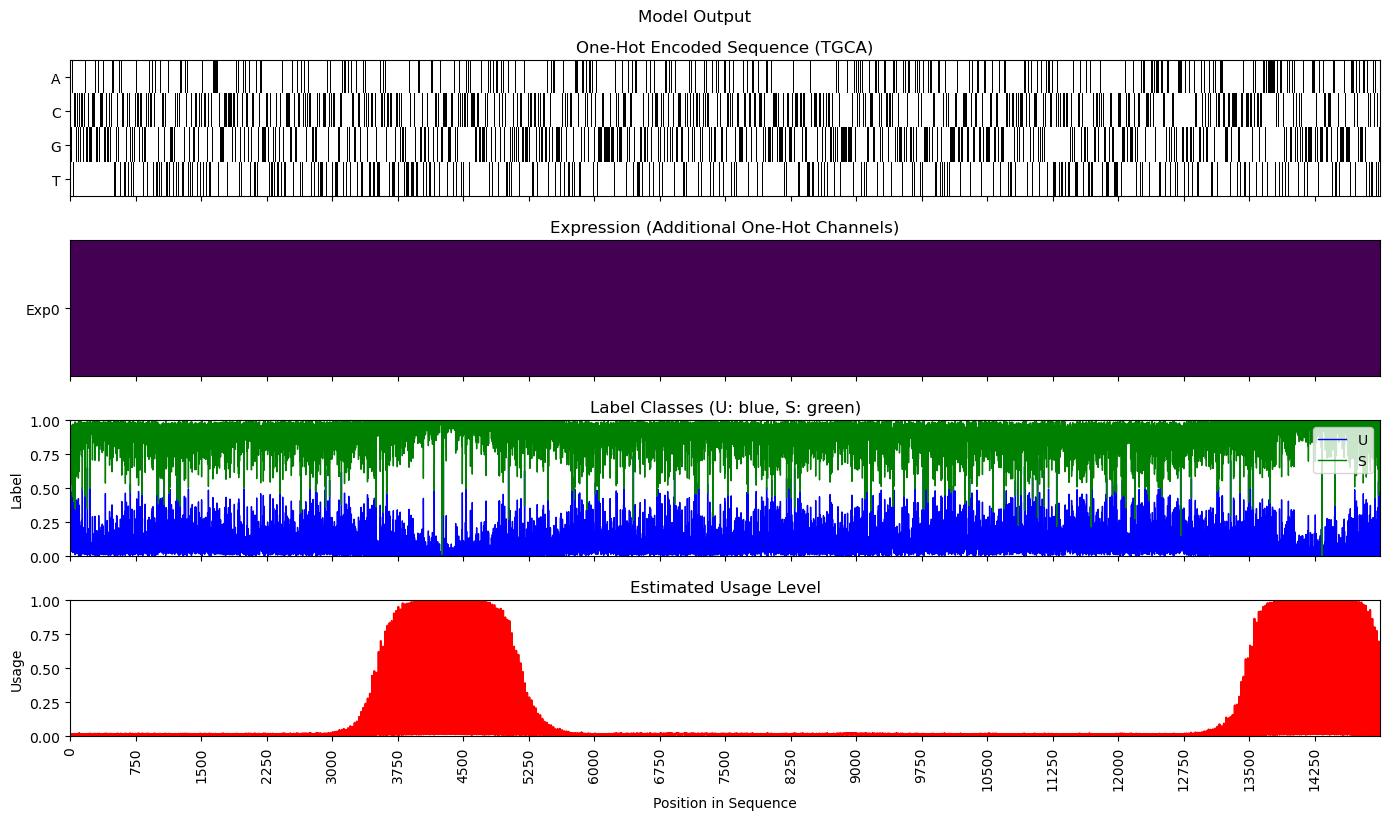

In [33]:
#Plot_2D_Array(test_output[i][:, 4200:4300])
#test_output.shape
#test_output.detach().cpu()[0, 0:3,:].shape
#test_predict_coordinates.shape
## echo 200
order_select = 0
cor_start = 0
cor_end = 15000

for i in range(10):
    print (i)
    pad_zeros = torch.zeros_like(test_output[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    test_predict_coordinates = torch.cat([pad_zeros, test_output[i], pad_zeros], dim=1)
    plot_one_hot_and_labels_zoom(training_input[i], test_output[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    break

0


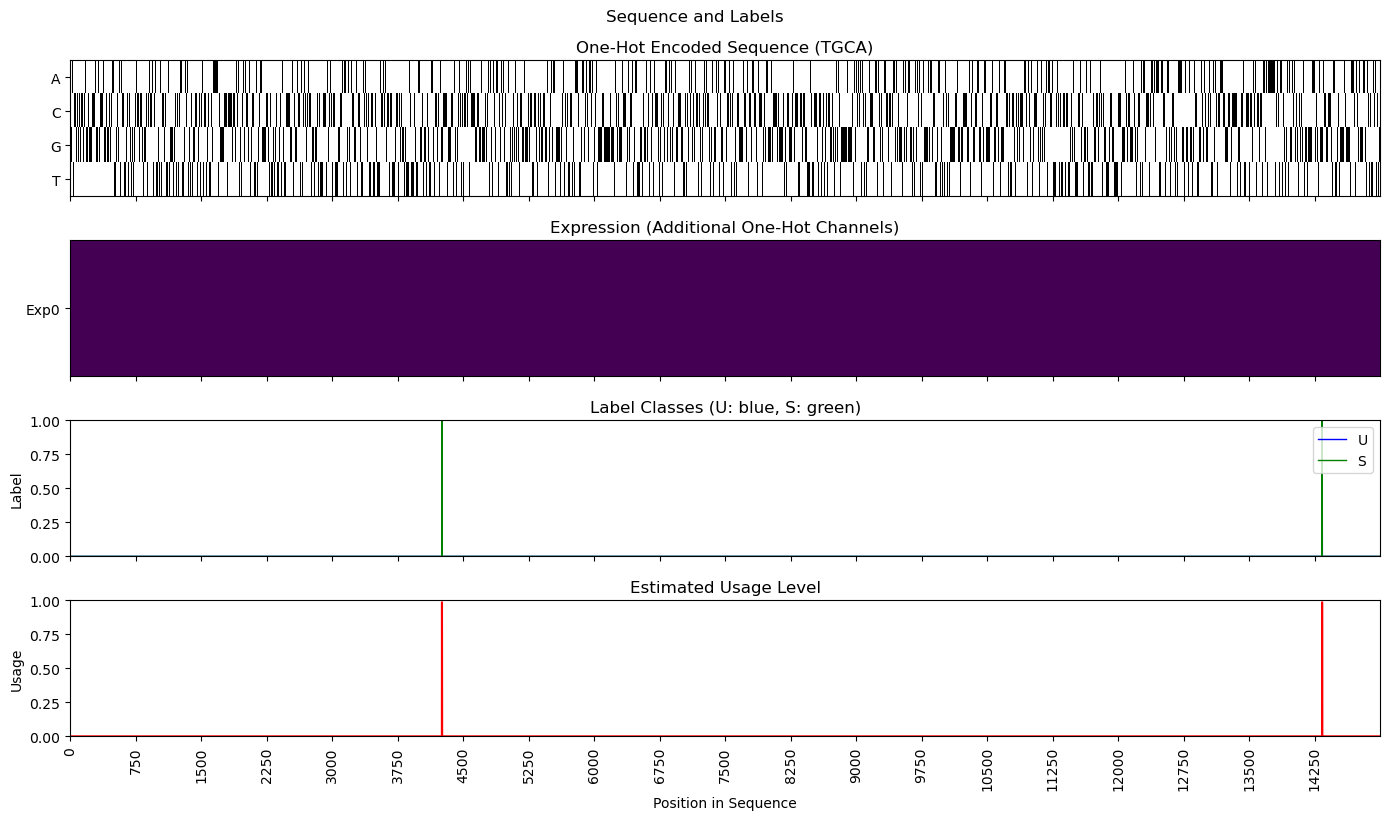

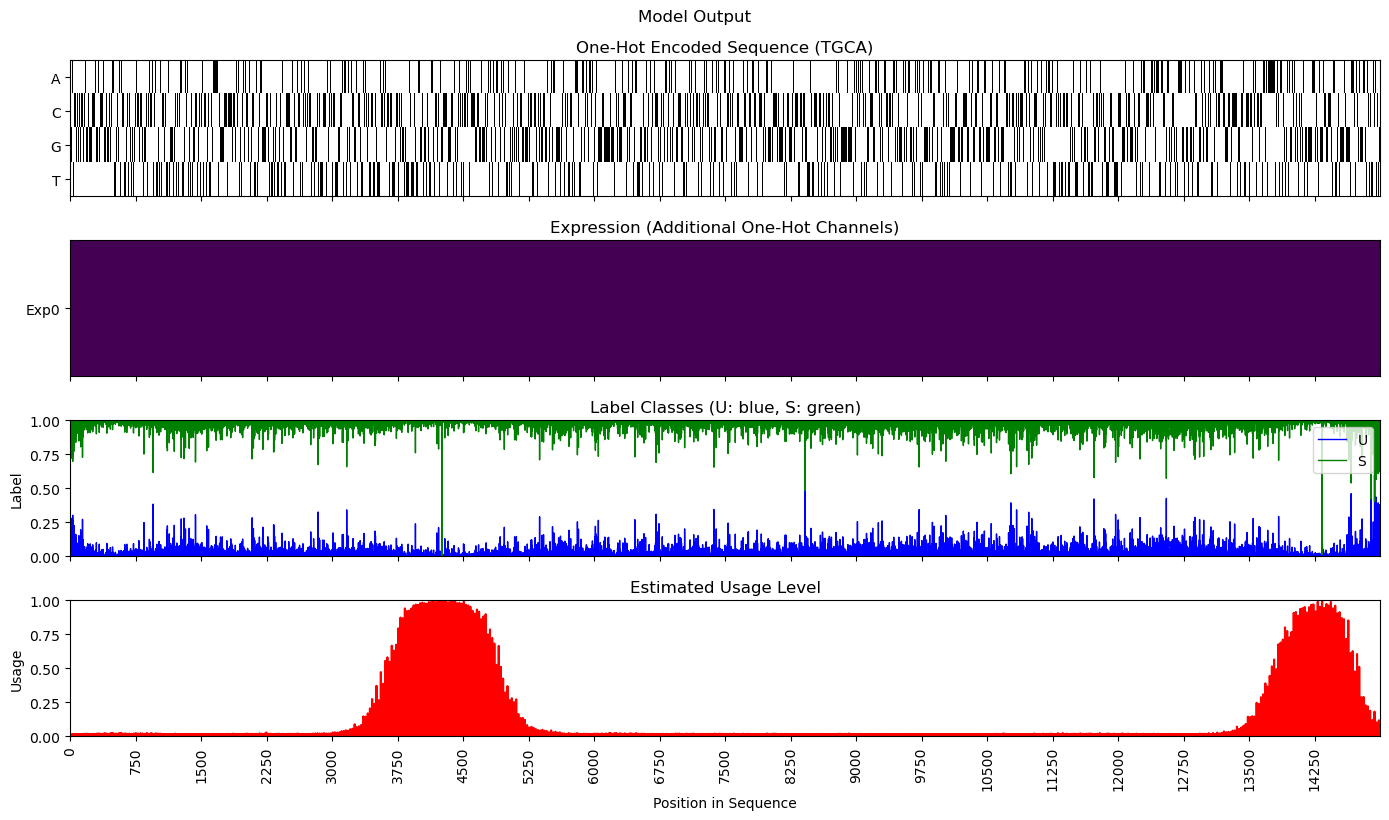

In [27]:
## echo 200
order_select = 0
cor_start = 0
cor_end = 15000

for i in range(10):
    print (i)
    pad_zeros = torch.zeros_like(test_output[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    test_predict_coordinates = torch.cat([pad_zeros, test_output[i], pad_zeros], dim=1)
    plot_one_hot_and_labels_zoom(training_input[i], test_output[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    break

0


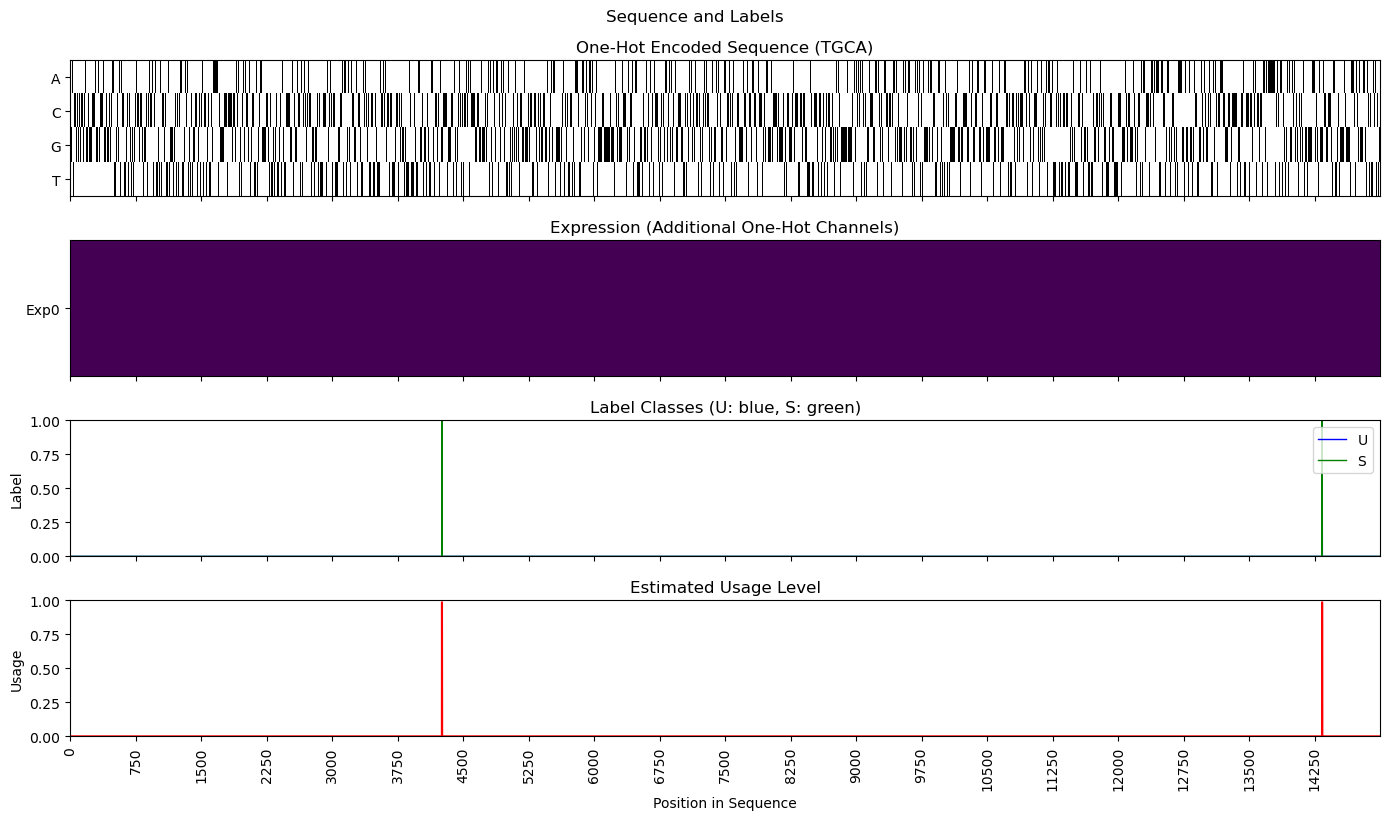

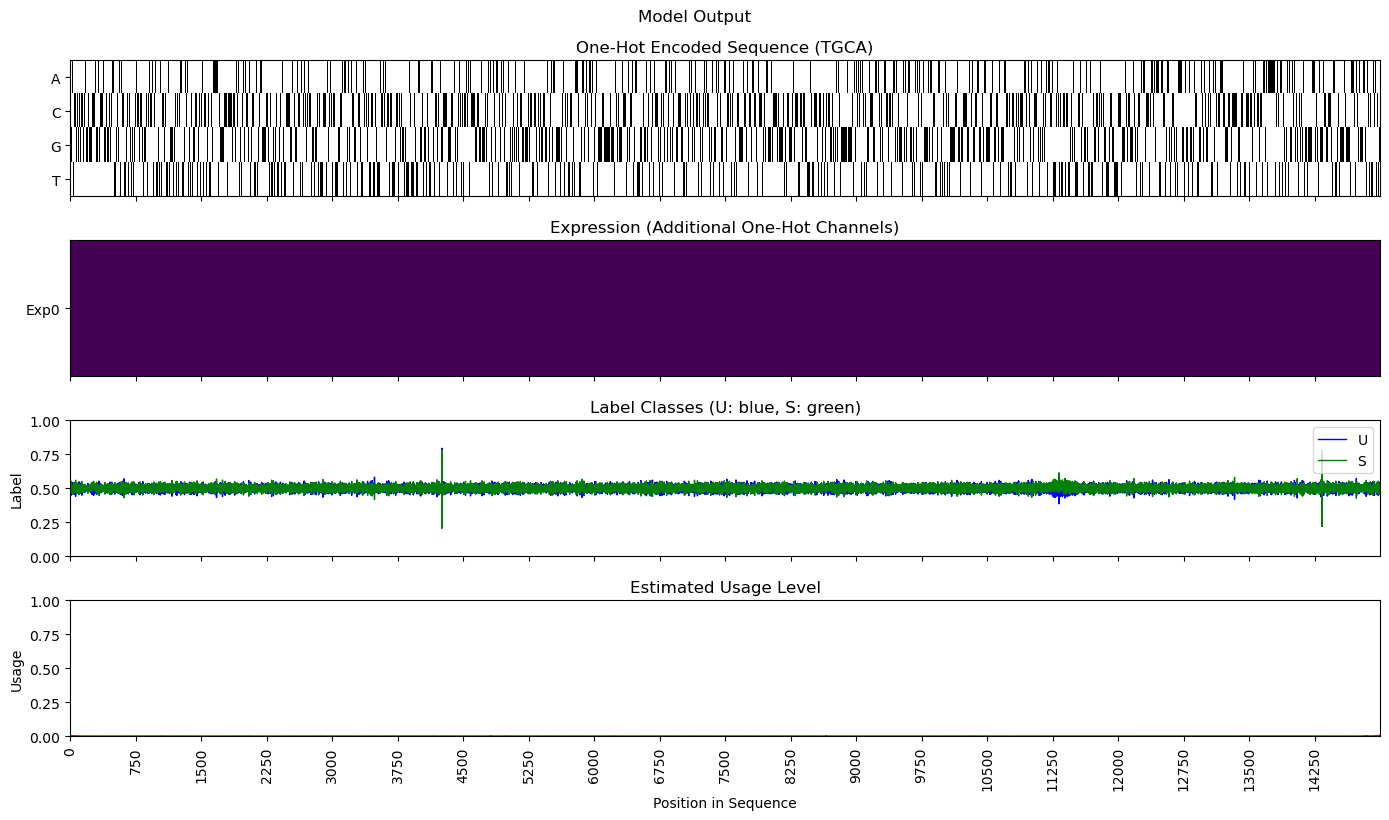

In [5]:
#plt.plot(test_output[2])
#plt.plot(test_predict_coordinates
order_select = 0
cor_start = 0
cor_end = 15000

for i in range(10):
    print (i)
    pad_zeros = torch.zeros_like(test_output[i])
    plot_one_hot_and_labels_zoom(training_input[i], training_label[i], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")
    test_predict_coordinates = torch.cat([pad_zeros, test_output[i], pad_zeros], dim=1)
    plot_one_hot_and_labels_zoom(training_input[i], test_output[i],
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")
    break

Number of N: 0 out of 15000


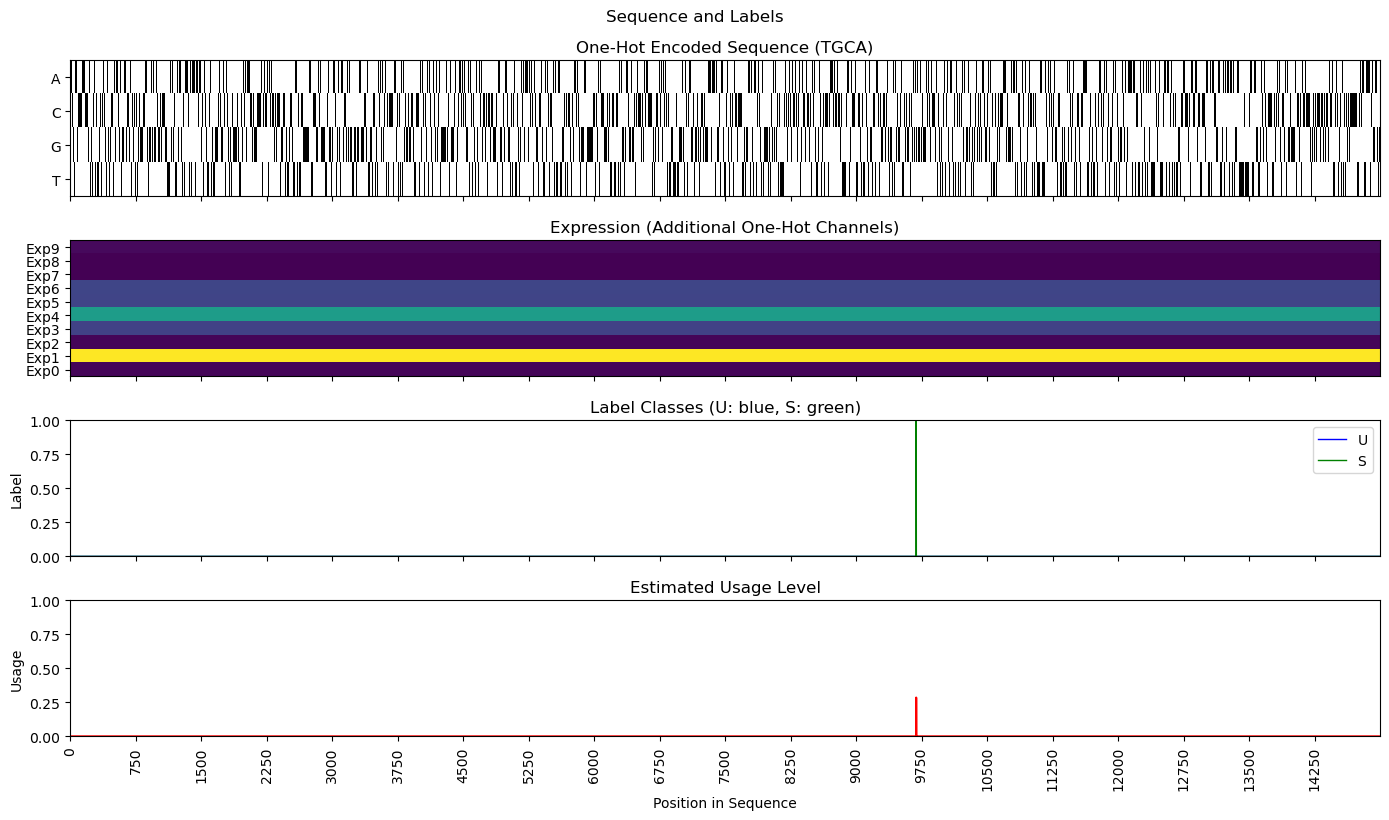

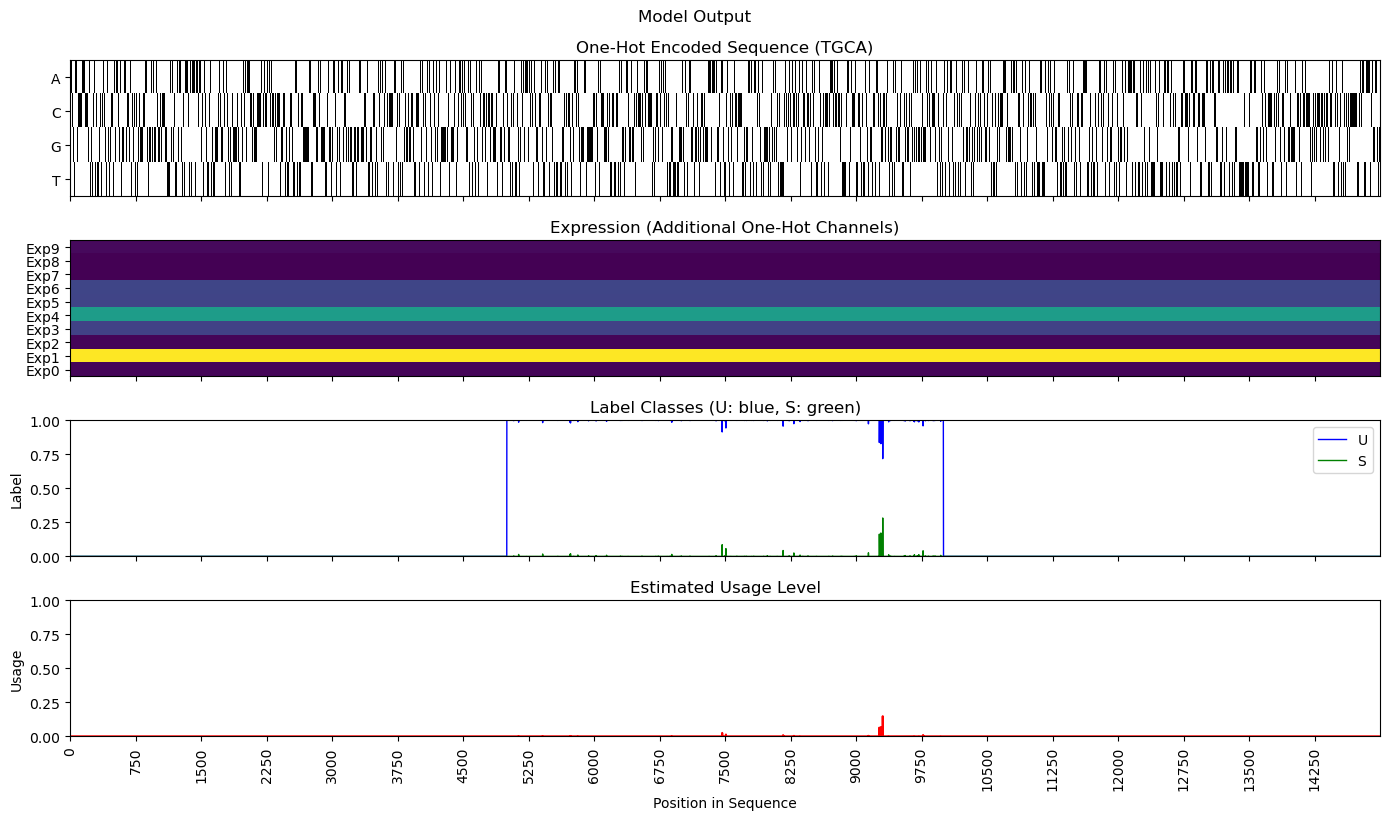

In [46]:
order_select = 7

test_data = training_input[order_select:order_select+1, :4, :].to(device)
#test_data = training_input[order_select:order_select+1, :14, :].to(device)

print("Number of N:", decode_one_hot(training_input[order_select][0:4, :]).count('N'), "out of 15000")
test_output = seq_model(test_data).detach().cpu()[0, 0:3,:]

cor_start = 0
cor_end = 15000

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


test_predict_coordinates = torch.cat([torch.zeros_like(test_output), test_output, torch.zeros_like(test_output)], dim=1)
plot_one_hot_and_labels_zoom(training_input[order_select], test_predict_coordinates,
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")

Number of N: 0 out of 15000


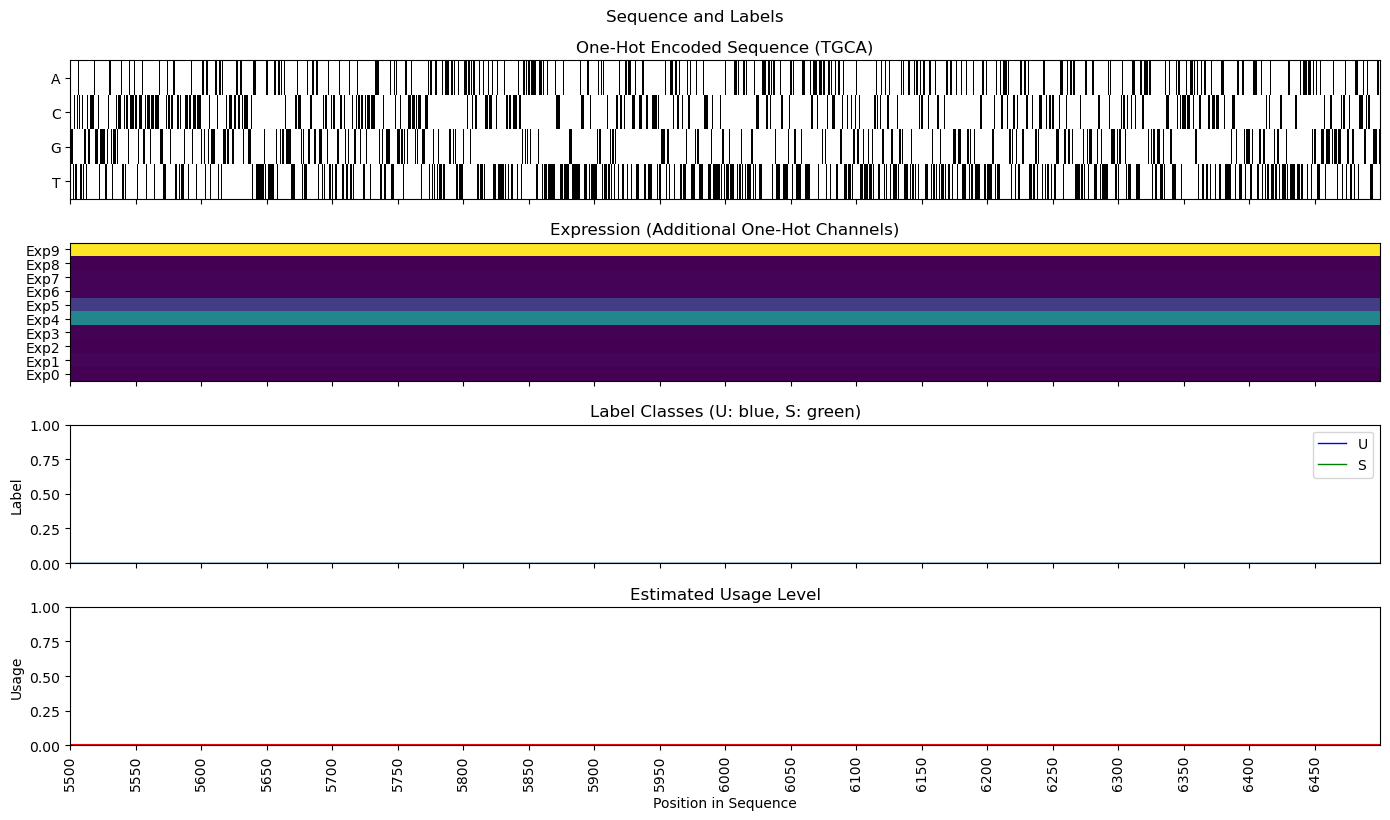

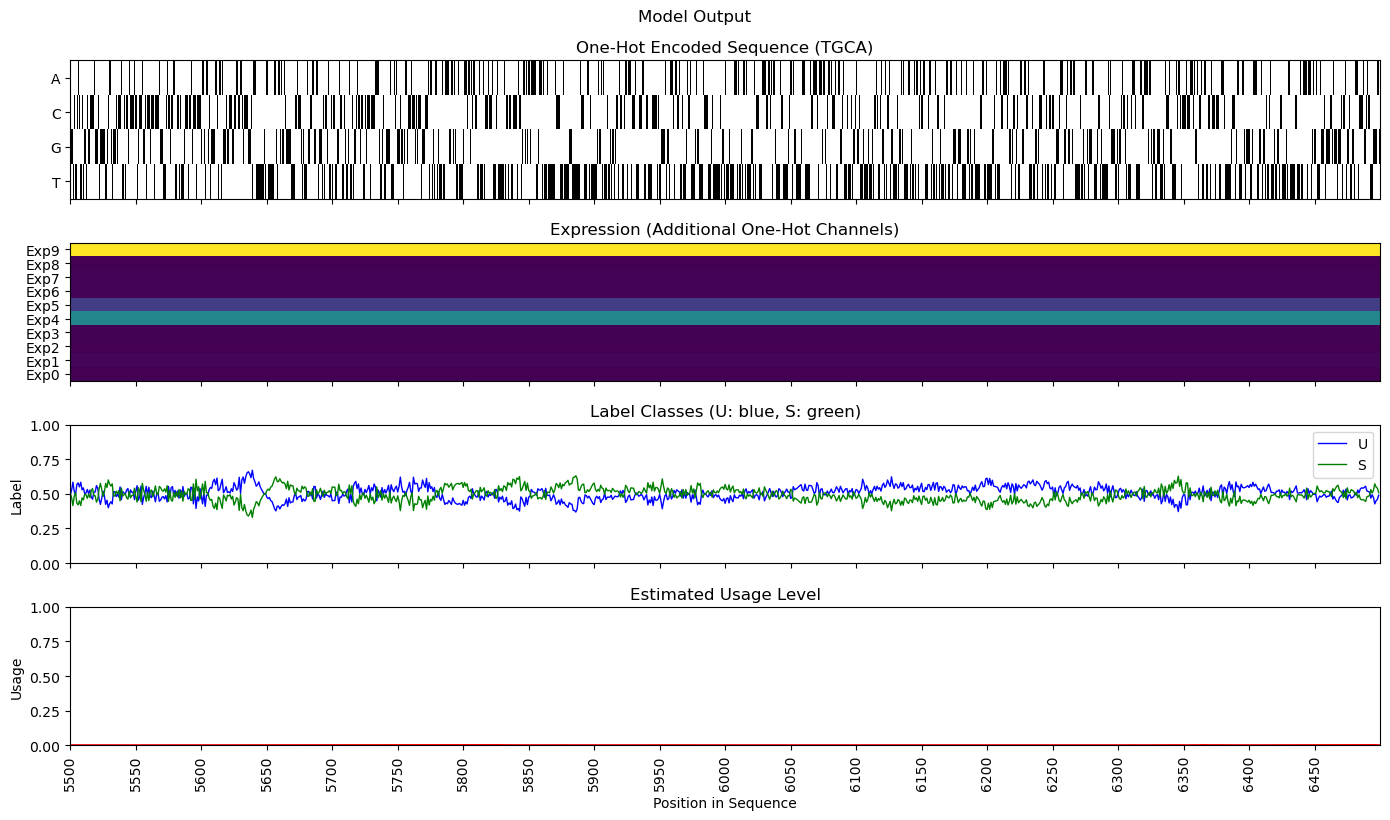

In [66]:
order_select = 0
test_data = training_input[order_select:order_select+1, :14, :].to(device)
print("Number of N:", decode_one_hot(training_input[order_select][0:4, :]).count('N'), "out of 15000")
test_output = seq_model(test_data)

cor_start = 5500
cor_end = 6500

plot_one_hot_and_labels_zoom(training_input[order_select], training_label[order_select], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Sequence and Labels")


plot_one_hot_and_labels_zoom(training_input[order_select], test_output.detach().cpu()[0, 0:3,:], 
                             zoom_start=cor_start, zoom_end=cor_end, title="Model Output")

In [ ]:
#Load the Pretrained Model
seq_model = Pangolin(L=L, W=W, AR=AR)
state_dict = torch.load("Model/102_samples_sequence_exp_model.pt", map_location=device, weights_only=True)
seq_model.load_state_dict(state_dict)

# Move model to GPU################
seq_model.to(device)
###################################
# ⛳ CRITICAL: Check device of model weights
print("Model device:", next(seq_model.parameters()).device)

# Load preprocessed training data
data = torch.load("102_training_data_sequece_exp.pt", weights_only=True)
training_input =  torch.stack(data['X'])  # Each: [N, 4, 15000] # Input:
training_label = torch.stack(data['y'])  # Each: [N, 12, 5000] # Label:

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
test_data = training_input[0:100].to(device)

#og_output = og_model(input_data)

In [11]:
test_data[0].shape

torch.Size([4, 15000])